Import an image to measure the background noise in it.

Note that Dragonfly007 (T13110627) had the G filter installed.

In [78]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid

import get_halpha_SB

%matplotlib inline

machine = 'coho'

### Looking at the actual Dragonfly data...

In [5]:
if machine == 'chinook':
    homedir = '/Users/lokhorst/Desktop/'
if machine == 'coho':
    homedir = '/Users/deblokhorst/Desktop/'
    
imagefile=homedir+'T13110627_36_light.fits'
d,h = fits.getdata(imagefile,header=True)

print h['EXPTIME']

600.0


the median of the whole frame is 2028.0
the median of the small box of data is 1907.0
the standard deviation of the small box is 266.424744741
the median of the small box of data MASKED is 1907.0
the standard deviation of the small box MASKED is 60.1782741629


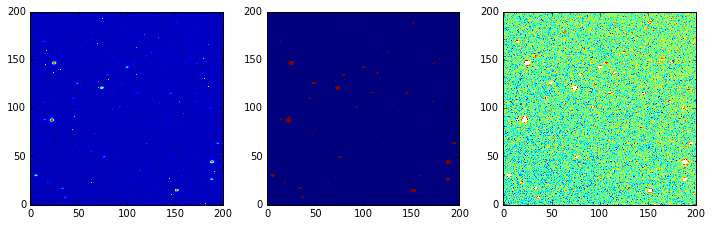

In [75]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

# Plot a portion of the image
smaller_d = d[200:400,200:400]
print "the median of the whole frame is %s"%np.median(d)
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 16))
plotdata(np.log10(smaller_d),ax=ax1)

# Make a 3sigma mask
mask = np.zeros(smaller_d.shape)
med_data = np.median(smaller_d)
sigma_data = np.std(smaller_d)
mask[smaller_d>(med_data+1.*sigma_data)]=1.
print "the median of the small box of data is %s"%med_data
print "the standard deviation of the small box is %s"%sigma_data

# Plot the mask
plotdata(mask,ax=ax2)

# Try and mask the data with the 3sigma mask
mx = np.ma.masked_array(smaller_d, mask=mask)
med_masked = np.ma.median(mx)
sigma_masked = np.ma.std(mx)
print "the median of the small box of data MASKED is %s"%med_masked
print "the standard deviation of the small box MASKED is %s"%sigma_masked

plotdata(mx,ax=ax3)

# grow the mask a bit in all directinos
#growmask = morphology.grey_dilation(mask,(3,3))

plt.tight_layout()

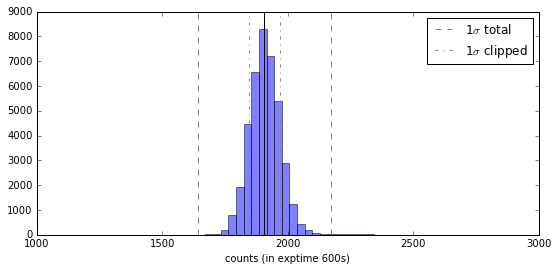

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
ax1.hist(np.ravel((smaller_d)),edgecolor='black', alpha = 0.5,bins=500)
ax1.set_xlim(1000,3000)
ax1.set_ylim(0,9000)
ax1.set_xlabel('counts (in exptime 600s)')

# line for the median of the total data
ax1.plot([med_data,med_data],[0,9000],color = 'blue')

# line for the median of the masked array
ax1.plot([med_masked,med_masked],[0,9000],'black')

# line for the standards deviations of total data and of the masked array
ax1.plot([med_data-sigma_data,med_data-sigma_data],[0,9000],'--',color='gray',label=r'1$\sigma$ total')
ax1.plot([med_data+sigma_data,med_data+sigma_data],[0,9000],'--',color='gray')

ax1.plot([med_masked-sigma_masked,med_masked-sigma_masked],[0,9000],'-.',color='gray',label=r'1$\sigma$ clipped')
ax1.plot([med_masked+sigma_masked,med_masked+sigma_masked],[0,9000],'-.',color='gray')
plt.legend()
plt.show()

The noise should be distributed in some normal or Poisson distribution, and that is what we see here.  The dashed lines are the standard deviation of the whole array, and the dash-dotted lines are the standard deviation of the sigma-clipped array.

### Adding noise from the G-band and comparing it to noise in the image

### Looking at the Needle image - measure S/N ratio in single frames and coadd

In [16]:
imagefile=homedir+'2017-04-02_coadd_SloanG.fits'
d_needle279,h_needle279 = fits.getdata(imagefile,header=True)

print np.float(h_needle279['NFRAMES'])

imagenames=[]
if machine=='chinook':
    imagenames = ['2017-04-02_T13090552_16_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110598_31_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_36_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090562_23_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13110625_22_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110630_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090571_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_21_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110630_40_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13100579_15_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
              '2017-04-02_T13110627_26_light_ds_ff_wcs_sms_reg_pcp_pcr.fits']
if machine=='coho':
    imagenames = ['2017-04-02_T13090552_16_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090562_23_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13090571_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
              '2017-04-02_T13100579_15_light_ds_ff_wcs_sms_reg_pcp_pcr.fits']

image = homedir+imagenames[0]
d_needle1,h_needle1 = fits.getdata(image,header=True)

279.0


First we are going to look at the *noise* by masking out bright stars in the image and then looking at the distribution of the underlying noise.

the median of the small box of data before clipping is 1098.18153049
the standard deviation is 773.480526333
the median of the small box of data MASKED is 1097.77653497
the standard deviation MASKED is 4.42160090995



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


the median of the small box of data before clipping is 13.3366
the standard deviation is 882.395
the median of the small box of data MASKED is 12.0663347244
the standard deviation MASKED is 69.2133225284


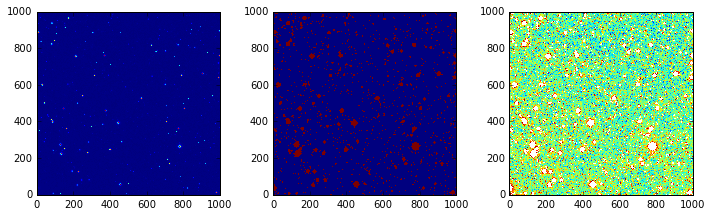

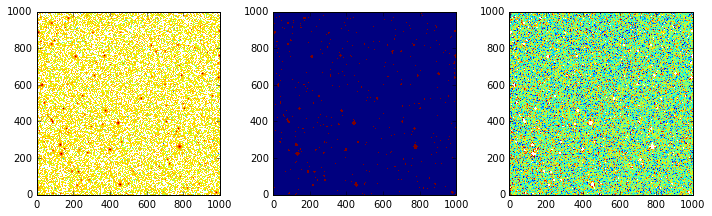

In [102]:
def maskbox(data,center_x,center_y,size=100,niter=5):
    smaller_d = data[center_x-size:center_x+size,center_y-size:center_y+size]
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 16))
    plotdata(np.log10(smaller_d),ax=ax1)
    
    med_data   = np.median(smaller_d)
    sigma_data = np.std(smaller_d)
    print "the median of the small box of data before clipping is %s"%med_data
    print "the standard deviation is %s"%sigma_data
    
    # do iterative sigma clipping to get rid of bright stars
    clipped_d  = sigma_clip(smaller_d, sig=3, iters = niter)
    outliers   = clipped_d.mask
    plotdata(outliers,ax=ax2)
    
    # Then mask the image with that
    mx = np.ma.masked_array(smaller_d, mask=outliers)
    med_masked = np.ma.median(mx)
    sigma_masked = np.ma.std(mx)
    print "the median of the small box of data MASKED is %s"%med_masked
    print "the standard deviation MASKED is %s"%sigma_masked
    plotdata(mx,ax=ax3)

    # grow the mask a bit in all directinos
    # growmask = morphology.grey_dilation(mask,(3,3))
    plt.tight_layout()
    
    return

maskbox(d_needle279,2100,2100,size=500)
print ""
maskbox(d_needle1,2100,2100,size=500)

1891.0
2135.0


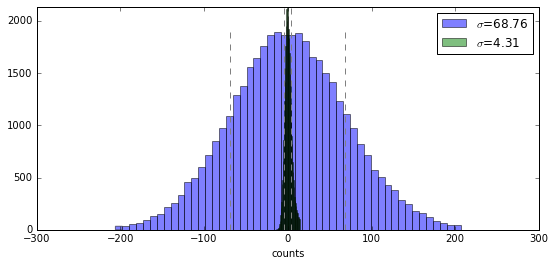

In [28]:
def plothist(data,center_x,center_y,ax=None,color=None,zero=True,label='',size=100,niter=5):
    smaller_d = data[center_x-size:center_x+size,center_y-size:center_y+size]
    
    # ravel out the array
    clipped_zp  = sigma_clip(np.ravel(smaller_d), sig=3, iters = niter)
    outliers    = clipped_zp.mask
    mx = np.ma.masked_array(np.ravel(smaller_d), mask=outliers)[~outliers]
    med_masked = np.median(mx)
    sigma_masked = np.std(mx)
    if len(label)>0:
        label=r'$\sigma$=%.2f, %s'%(sigma_masked,label)
    else:
        label=r'$\sigma$=%.2f'%sigma_masked    
    if zero:
        y,x,_ = ax1.hist(mx-med_masked,edgecolor='black', alpha = 0.5,bins=50,color=color,label=label)
        maxy = y.max()
        ax1.plot([0-sigma_masked,0-sigma_masked],[0,maxy],'--',color='gray')#,color='light'+color)
        ax1.plot([0+sigma_masked,0+sigma_masked],[0,maxy],'--',color='gray')#,color='light'+color)
    else:
        y,x,_ = ax1.hist(mx,edgecolor='black', alpha = 0.5,bins=50,color=color)
        maxy = y.max()
        ax1.plot([med_masked,med_masked],[0,maxy],'black')
        ax1.plot([med_masked-sigma_masked,med_masked-sigma_masked],[0,maxy],'--',color='gray')
        ax1.plot([med_masked+sigma_masked,med_masked+sigma_masked],[0,maxy],'--',color='gray')
        
    ax1.set_xlabel('counts')
    ax1.set_ylim(0,maxy)
    print maxy
    return sigma_masked

fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
sigma_1   = plothist(d_needle1,2100,2100,ax=ax1,color='blue')
sigma_279 = plothist(d_needle279,2100,2100,ax=ax1,color='green')
plt.legend()

In [12]:
expnum_279 = 279.
expnum_1 = 1.
print "The square root of the time ratio is %s." % np.sqrt(expnum_279/expnum_1)
print "The ratio of signal to noise is %s. " % (sigma_1/sigma_279)

print "i.e. if the noise is increasing with the square root of the exposure time increase, sigma_1/sigma_279 times sqrt{1/279} should equal 1."
print "And it equals %s, which is close enough!" % (sigma_1/sigma_279*np.sqrt(expnum_1/expnum_279))

The square root of the time ratio is 16.7032930885.
The ratio of signal to noise is 15.9682581865. 
i.e. if the noise is increasing with the square root of the exposure time increase, sigma_1/sigma_279 times sqrt{1/279} should equal 1.
And it equals 0.955994611477, which is close enough!


Let's do it for a bunch more frames

46980.0
47129.0
47009.0
46951.0
55414.0
The mean sigma of the 4 frames (in a box of size 500) is 66.3852986372.


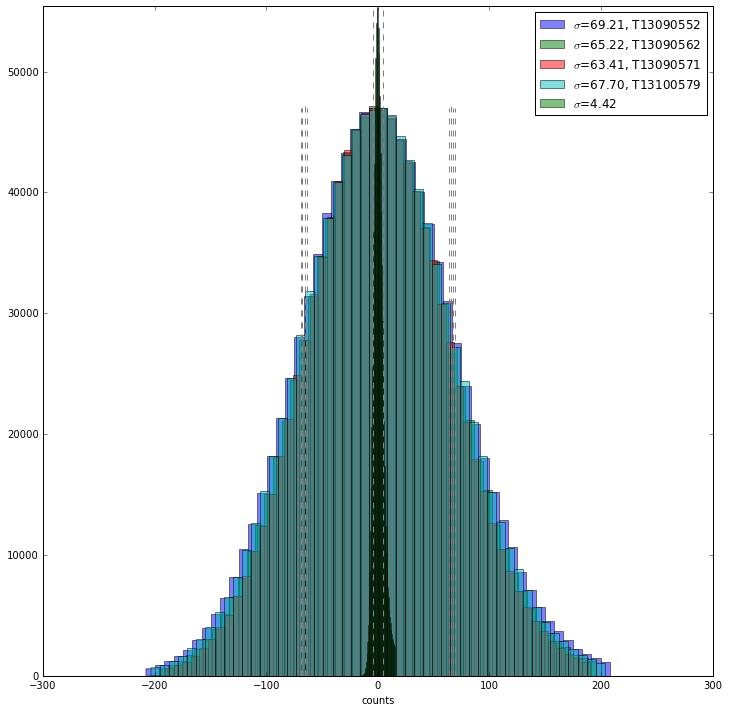

In [40]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
size=500
sigmalist = []
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    sigma   = plothist(d_needle,2100,2100,ax=ax1,label=image.split('_')[1],size=size)
    sigmalist.append(sigma)
sigma_279 = plothist(d_needle279,2100,2100,ax=ax1,color='green',size=size)
plt.legend()

sigmalist=np.array(sigmalist)
print "The mean sigma of the %s frames (in a box of size %s) is %s." %(len(imagenames),size,np.mean(sigmalist))

Try it after binning the data slightly.

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


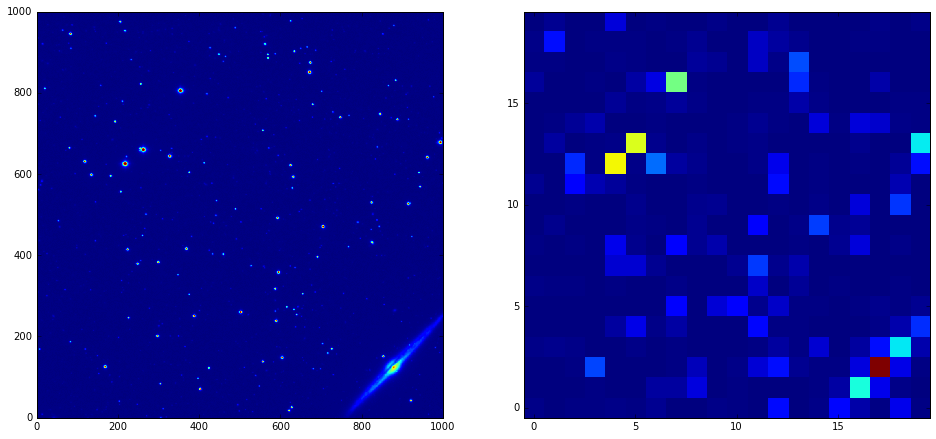

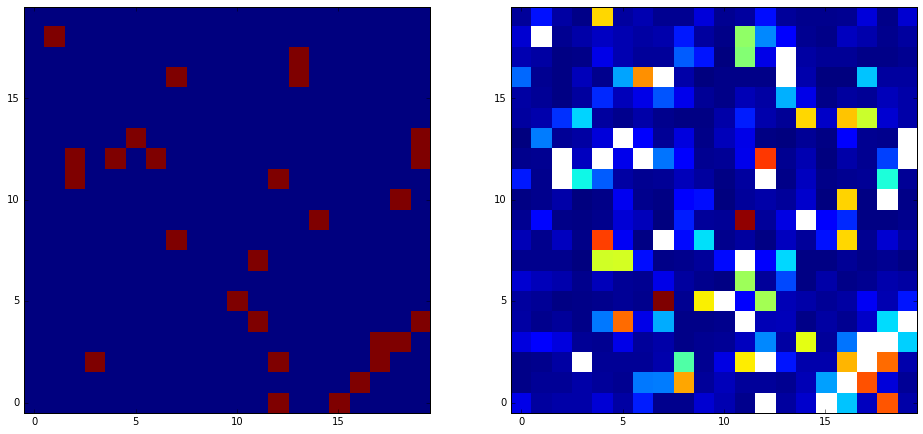

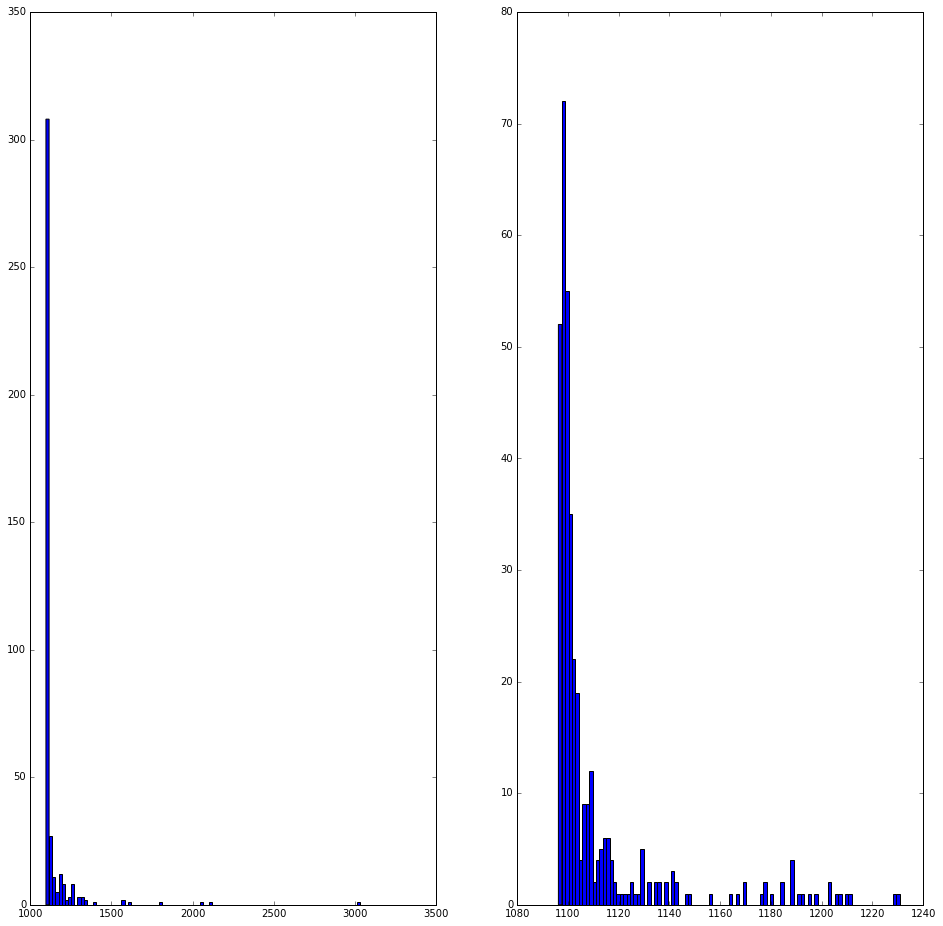

In [108]:
image = d_needle279
scale = 150 # arcsec
pixelscale = 3.0 #arcsec per pixel
## TO TEST: image = np.array([[1,2,3,4],[4,5,6,7],[7,8,9,10],[11,12,13,14]])
factor = scale/pixelscale
lowres = get_halpha_SB.imreduce(image, factor, log=False, method = 'average')  ## the data

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(np.log10(image[40*factor:60*factor,40*factor:60*factor]),ax=ax1)
plotdata(np.log10(lowres[40:60,40:60]),ax=ax2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
clipped_d  = sigma_clip(lowres[40:60,40:60], sig=3, iters = 2)
outliers   = clipped_d.mask  ## the mask
plotdata(outliers,ax=ax1)
mx = np.ma.masked_array(lowres[40:60,40:60], mask=outliers)
plotdata(mx,ax=ax2)

imreduce_mask(lowres[40:60,40:60],outliers,factor)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.hist(np.ravel(lowres[40:60,40:60]),bins=100);
clipped_zp  = sigma_clip(np.ravel(lowres[40:60,40:60]), sig=3, iters = 2)
outliers    = clipped_zp.mask
mx = np.ma.masked_array(np.ravel(lowres[40:60,40:60]), mask=outliers)[~outliers]
ax2.hist(np.ravel(mx),bins=100);


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


the median of the small box of data before clipping is 0.0
the standard deviation is 0.0
the median of the small box of data MASKED is 0.0
the standard deviation MASKED is 0.0
the median of the small box of data before clipping is 0.0
the standard deviation is 0.0
the median of the small box of data MASKED is 0.0
the standard deviation MASKED is 0.0
the median of the small box of data before clipping is 0.0
the standard deviation is 0.0
the median of the small box of data MASKED is 0.0
the standard deviation MASKED is 0.0
the median of the small box of data before clipping is 0.0
the standard deviation is 0.0
the median of the small box of data MASKED is 0.0
the standard deviation MASKED is 0.0


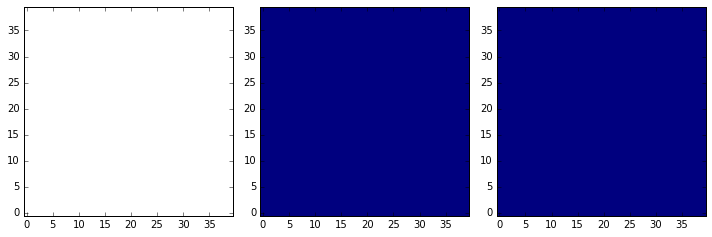

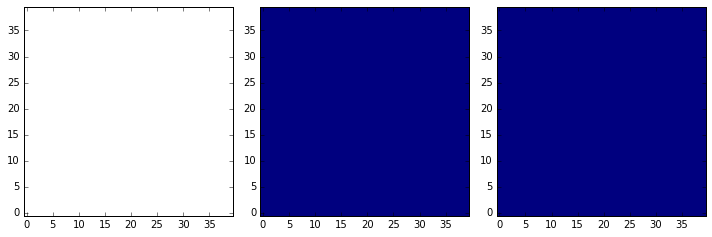

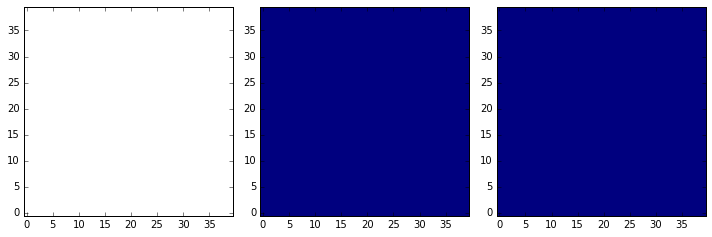

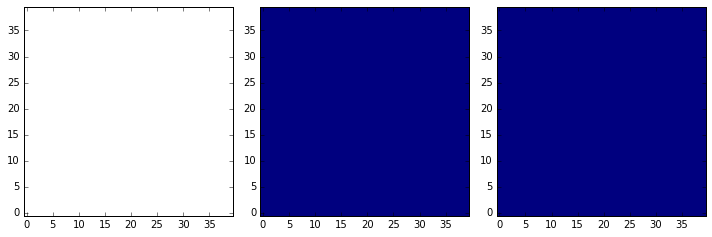

In [90]:
size=20; x_center = 60; y_center = 60
factor=2
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    lowres = get_halpha_SB.imreduce(d_needle, factor, log=False, method = 'average')
    maskbox(lowres,center_x,center_y,size=size)


435.0
716.0
276.0
414.0
138.0
The mean sigma of the 4 frames (in a box of size 20) and binned by a factor of 50.0 is 7.1541835821.


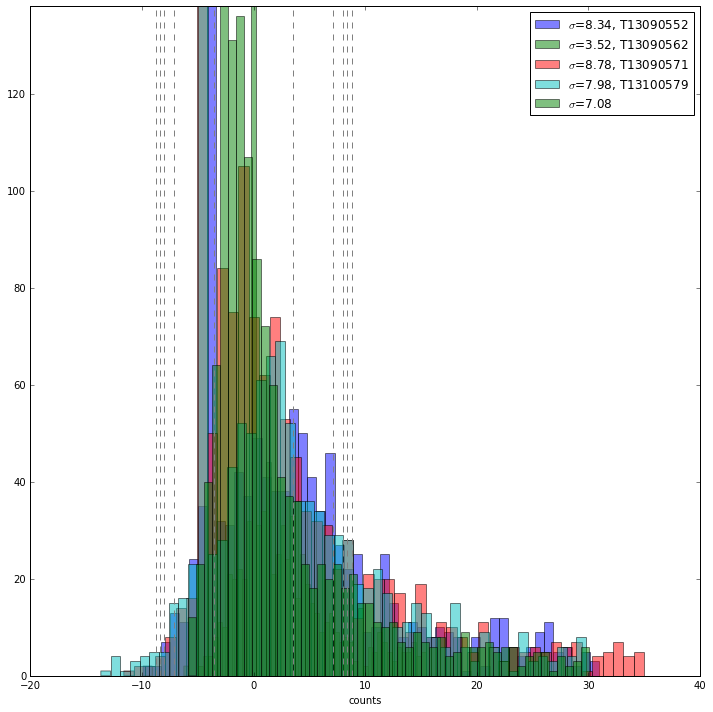

In [85]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
size=20; x_center = 60; y_center = 60
scale = 150 # arcsec
pixelscale = 3.0 #arcsec per pixel
factor = scale/pixelscale
sigmalist = []
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    lowres = get_halpha_SB.imreduce(d_needle, factor, log=False, method = 'average')
    sigma   = plothist(lowres,y_center,x_center,ax=ax1,label=image.split('_')[1],size=size)
    sigmalist.append(sigma)
lowres = get_halpha_SB.imreduce(d_needle279, factor, log=False, method = 'average')
sigma_279 = plothist(lowres,y_center,x_center,ax=ax1,color='green',size=size)
plt.legend()

sigmalist=np.array(sigmalist)
print "The mean sigma of the %s frames (in a box of size %s) and binned by a factor of %s is %s." \
        %(len(imagenames),size,factor,np.mean(sigmalist))

Now we need to find a star to measure the *signal* from.

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


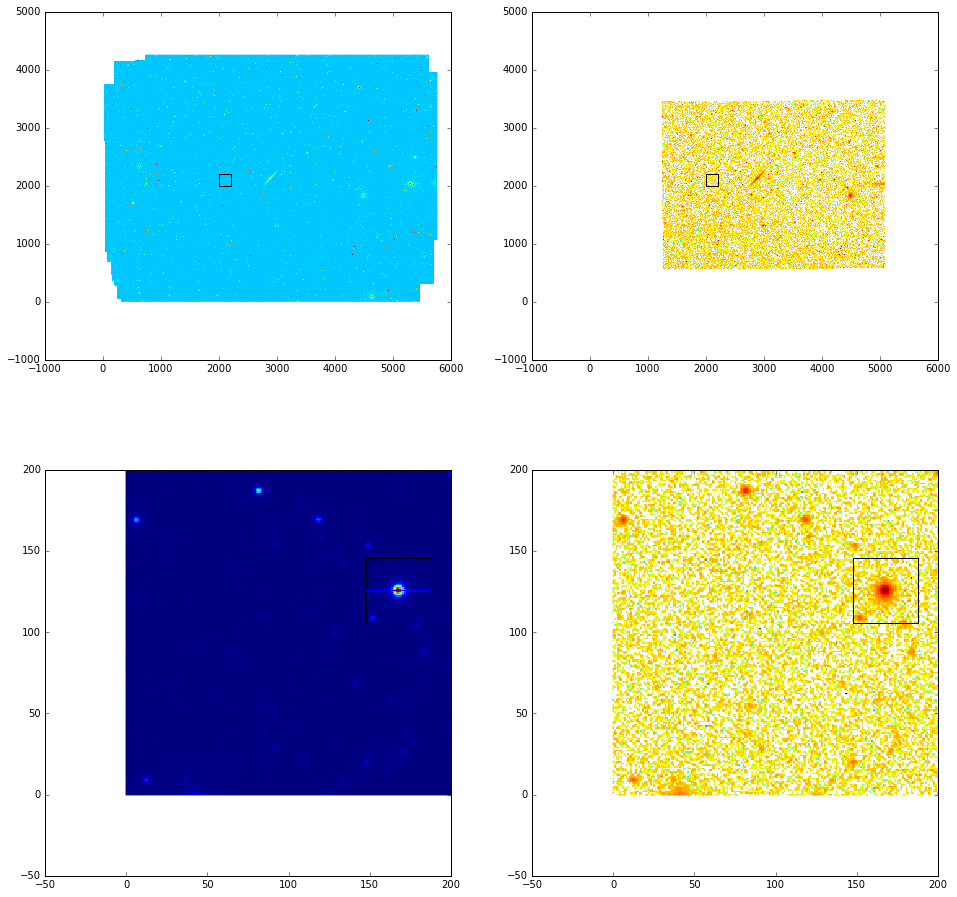

In [81]:
def plotbox(center_x=2100,center_y=2100,ax=None,size=100):
    ax.plot([center_x-size,center_x+size,center_x+size,center_x-size,center_x-size],\
            [center_y-size,center_y-size,center_y+size,center_y+size,center_y-size],'k-')

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 16))
plotdata(np.log10(d_needle279),ax=ax1)
plotdata(np.log10(d_needle1),ax=ax2)
center_x=2100; center_y=2100; size = 100
plotbox(center_x,center_y,ax=ax1,size=size)
plotbox(center_x,center_y,ax=ax2,size=size)
plotdata(np.log10(d_needle279[center_y-size:center_y+size,center_x-size:center_x+size]),ax=ax3)
plotdata(np.log10(d_needle1[center_y-size:center_y+size,center_x-size:center_x+size]),ax=ax4)
starx=168; stary=126
plotbox(starx,stary,ax=ax3,size=20)
plotbox(starx,stary,ax=ax4,size=20)
ax3.plot([starx-20,starx+20],[stary,stary])

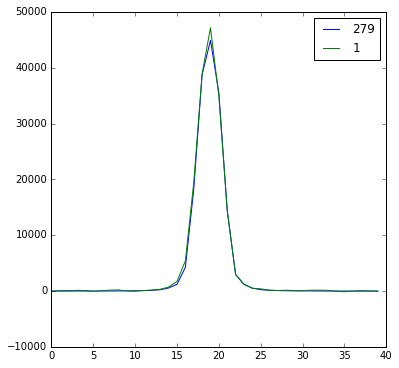

In [43]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
yval = center_y-100+stary
xval = center_x-100+starx

profile_needle279 = d_needle279[yval,xval-20:xval+20]
norm_needle279 = profile_needle279-np.mean(d_needle279[yval,xval-20:xval-10])
ax1.plot(np.arange(len(profile_needle279)),norm_needle279,label='279')

profile_needle1 = d_needle1[yval,xval-20:xval+20]
ax1.plot(np.arange(len(profile_needle1)),profile_needle1,label='1')

plt.legend()

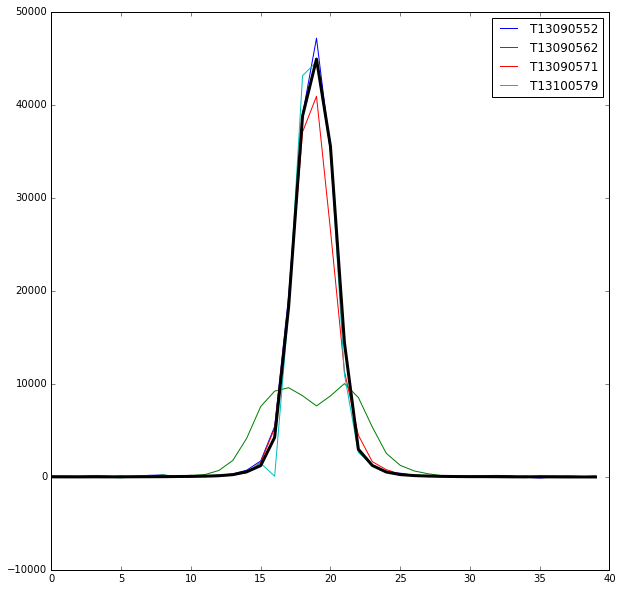

In [44]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
yval = center_y-100+stary
xval = center_x-100+starx

signallist=[]
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    profile_needle = d_needle[yval,xval-20:xval+20]
    ax1.plot(np.arange(len(profile_needle)),profile_needle,label=image.split('_')[1])
    signallist.append(np.max(profile_needle))
    
profile_needle279 = d_needle279[yval,xval-20:xval+20]
norm_needle279 = profile_needle279-np.mean(d_needle279[yval,xval-20:xval-10])
ax1.plot(np.arange(len(profile_needle279)),norm_needle279,linewidth=3,color='black')
plt.legend()

signallist = np.array(signallist)

In [196]:
print signallist
print signallist/sigmalist
print (np.max(norm_needle279)/sigma_279)/(signallist/sigmalist)

[ 47168.70703125  47974.08203125  45810.296875    10019.4453125
  30902.796875    43685.86328125  40914.828125    39637.95703125
  44314.75390625  44619.87109375  43146.6796875 ]
[  685.94301311   896.34048551  1115.67760085   155.81221126   486.73373417
   666.26096212   652.56875095   638.5780959    925.36352197   669.12790367
   735.44648896]
[ 15.20581095  11.63655993   9.34886545  66.94160678  21.42921077
  15.65500663  15.9834803   16.33366356  11.27159168  15.58793128
  14.18229597]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log10


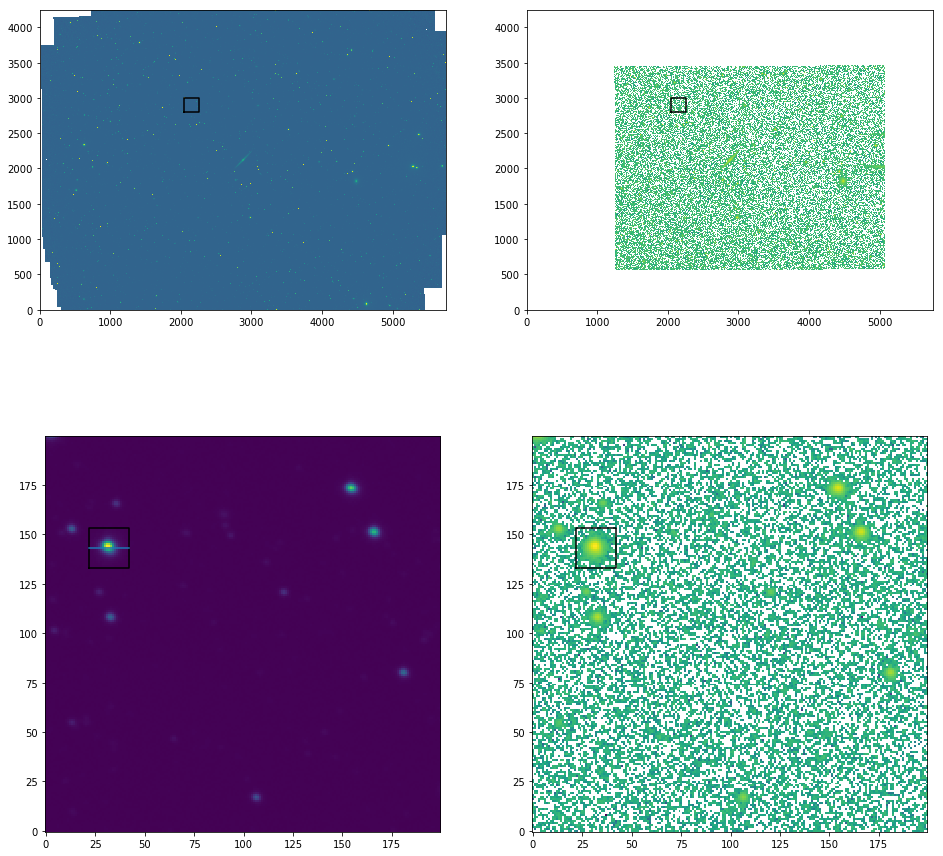

In [93]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 16))
plotdata(np.log10(d_needle279),ax=ax1)
plotdata(np.log10(d_needle1),ax=ax2)
center_x=2150; center_y=2900
plotbox(center_x,center_y,ax=ax1)
plotbox(center_x,center_y,ax=ax2)
plotdata(np.log10(d_needle279[center_y-100:center_y+100,center_x-100:center_x+100]),ax=ax3)
plotdata(np.log10(d_needle1[center_y-100:center_y+100,center_x-100:center_x+100]),ax=ax4)
starx=32; stary=143
plotbox(starx,stary,ax=ax3,size=10)
plotbox(starx,stary,ax=ax4,size=10)
ax3.plot([starx-10,starx+10],[stary,stary])

Plot a 1d profile across the star

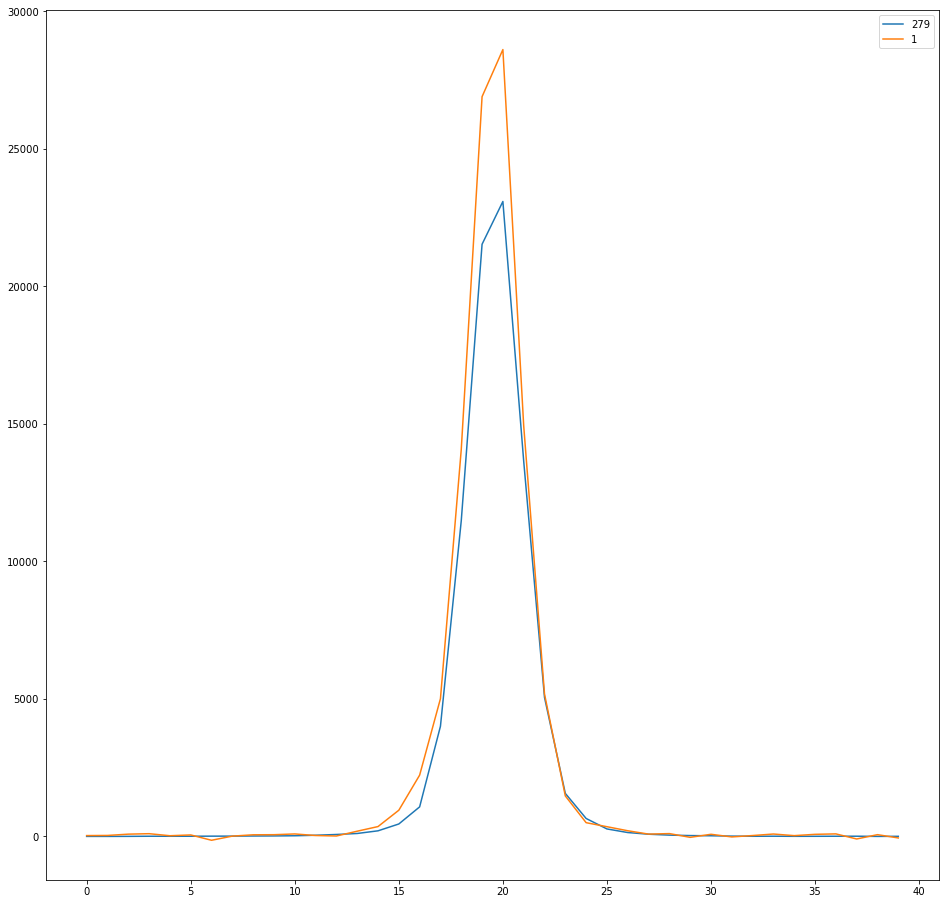

In [114]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 16))
yval = center_y-100+stary
xval = center_x-100+starx

profile_needle279 = d_needle279[yval,xval-20:xval+20]
norm_needle279 = profile_needle279-np.mean(d_needle279[yval,xval-20:xval-10])
ax1.plot(np.arange(len(profile_needle279)),norm_needle279,label='279')

profile_needle1 = d_needle1[yval,xval-20:xval+20]
ax1.plot(np.arange(len(profile_needle1)),profile_needle1,label='1')

plt.legend()
